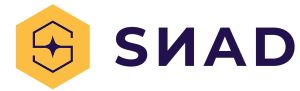

# MNIST dataset

This notebook gives an example of Active Anomaly Detection with `coniferest` and [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.

Developers of `conferest`:
- [Matwey Kornilov (MSU)](https://matwey.name)
- [Vladimir Korolev](https://www.linkedin.com/in/vladimir-korolev-a4195b86/)
- [Konstantin Malanchev (LINCC Frameworks / CMU)](https://homb.it), notebook author

**[Run this NB in Google Colab](https://colab.research.google.com/github/snad-space/coniferest/blob/master/docs/notebooks/mnist.ipynb)**

In [1]:
## Install and import the required libraries

In [2]:
# Install packages
%pip install coniferest
%pip install datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import datasets
import matplotlib.pyplot as plt
import numpy as np

from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.session import Session
from coniferest.session.callback import TerminateAfter, prompt_decision_callback, Label

/Users/hombit/.virtualenvs/coniferest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download and load the MNIST dataset

Download data from Hugging Faces with `datasets` library

In [4]:
mnist = datasets.load_dataset("mnist")

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 885902.21 examples/s]


Load the data into numpy arrays

In [5]:
images_train = np.asarray(mnist['train']['image'])
images_test = np.asarray(mnist['test']['image'])
digits_train = np.asarray(mnist['train']['label'])
digits_test = np.asarray(mnist['test']['label'])

images = np.concatenate([images_train, images_test])
digits = np.concatenate([digits_train, digits_test])

Plot some examples

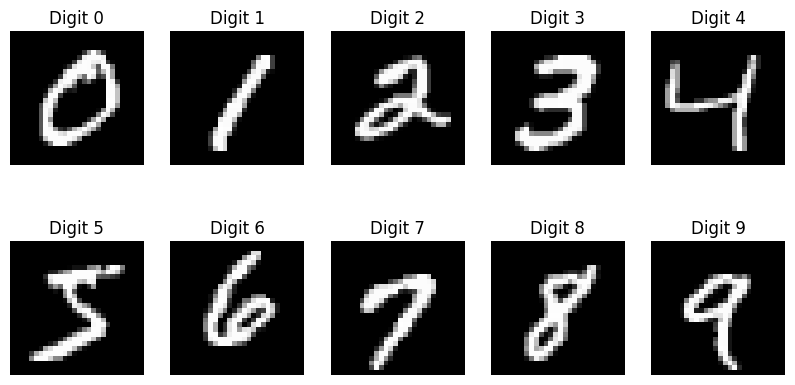

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[digits == i][0], cmap='gray')
    ax[i // 5, i % 5].set_title(f'Digit {i}')
    ax[i // 5, i % 5].axis('off')

## Preprocess the data

Select the data to use:
- `image` : the original images
- `fft` : the power spectrum of the images
- `both` : the original images and the power spectrum together

In [7]:
DATA = 'both'  # 'image', 'fft', 'both'

Make 2-d FFT of the images

In [8]:
# Make 2-d FFT of the images
data_fft = np.fft.fft2(images)
# Get power spectrum
power_spectrum = np.square(np.abs(data_fft))
# Normalize the power spectrum by zero frequency
power_spectrum = power_spectrum / power_spectrum[:, 0, 0][:, None, None]

Plot some examples of power spectrum

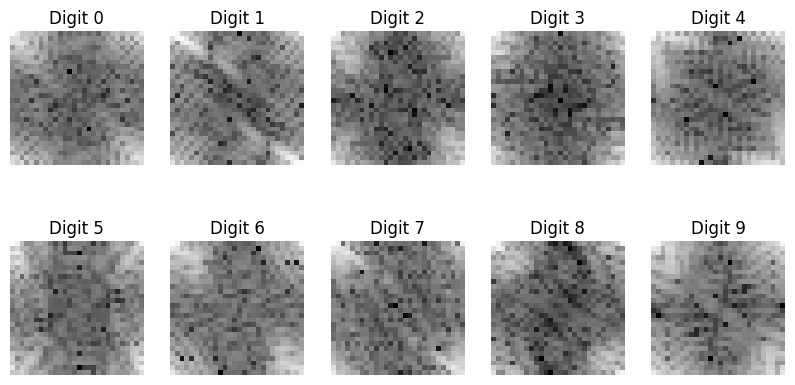

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax[i // 5, i % 5].imshow(np.log(power_spectrum[digits == i][0]), cmap='gray')
    ax[i // 5, i % 5].set_title(f'Digit {i}')
    ax[i // 5, i % 5].axis('off')

Concatenate images and power spectrum

In [10]:
if DATA == 'image':
    final = np.asarray(images, dtype=np.float32)
elif DATA == 'fft':
    final = np.asarray(power_spectrum.reshape(-1, 28 * 28), dtype=np.float32)
elif DATA == 'both':
    final = np.concatenate([images.reshape(-1, 28 * 28), power_spectrum.reshape(-1, 28 * 28)], axis=1)
else:
    raise ValueError(f"Unknown value for DATA: {DATA}")

## Classic anomaly detection with Isolation forest

In [11]:
model = IsolationForest(random_seed=10, n_trees=1000)
model.fit(np.array(final))
scores = model.score_samples(np.array(final))
ordered_index = np.argsort(scores)
ordered_digits = digits[ordered_index]

print(f"Top 10 weirdest digits : {ordered_digits[:10]}")
print(f"Top 10 most normal digits : {ordered_digits[-10:]}")

Top 10 weirdest digits : [6 5 5 5 3 7 5 5 9 5]
Top 10 most normal digits : [1 1 1 1 1 1 1 1 1 1]


Plot the top 10 weirdest digits and the top 10 most normal digits

Text(0.1, 0.5, 'Top 10 most normal digits')

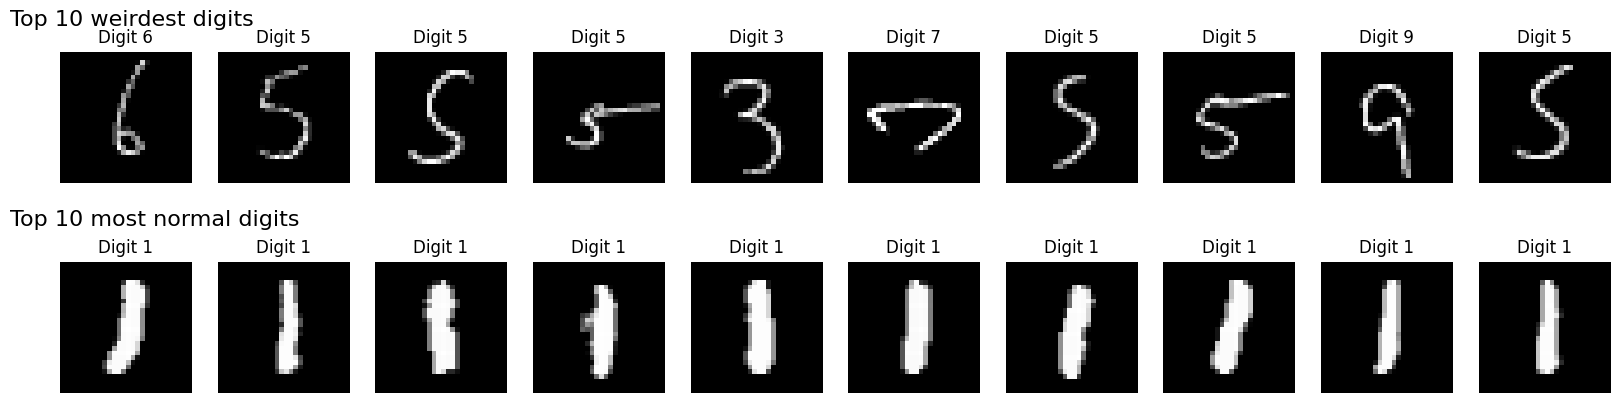

In [12]:
fig, ax = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    ax[0, i].imshow(images[ordered_index[i]], cmap='gray')
    ax[0, i].set_title(f'Digit {ordered_digits[i]}')
    ax[0, i].axis('off')
    ax[1, i].imshow(images[ordered_index[-i - 1]], cmap='gray')
    ax[1, i].set_title(f'Digit {ordered_digits[-i - 1]}')
    ax[1, i].axis('off')
fig.text(0.1, 0.9, 'Top 10 weirdest digits', ha='left', va='center', fontsize=16)
fig.text(0.1, 0.5, 'Top 10 most normal digits', ha='left', va='center', fontsize=16)

## Anomaly detection with PineForest

Set expert budget

In [13]:
EXPERT_BUDGET = 20

First, we need a function which would show us an image, its label and ask us if it is an anomaly.

Let's say that even numbers are anomalies

In [14]:
def decision(index, x, session):
    digit, image = digits[index], images[index]
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Digit {digit}')
    ax.axis('off')
    plt.show()

    ### UNCOMMENT TO MAKE IT INTERACTIVE
    # return prompt_decision_callback(index, x, session)

    # Non-interactive
    return Label.ANOMALY if digit % 2 == 0 else Label.REGULAR

Create a model and a session.

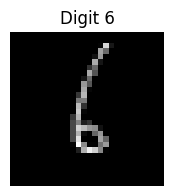

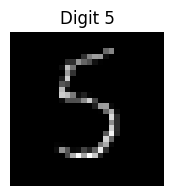

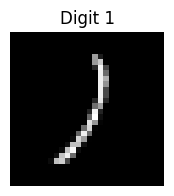

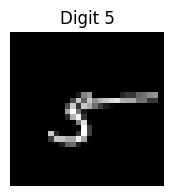

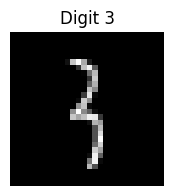

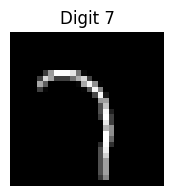

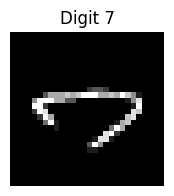

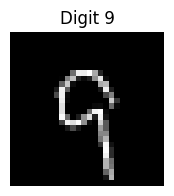

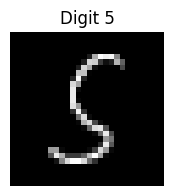

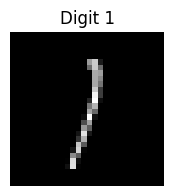

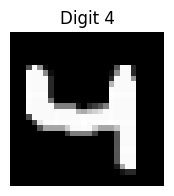

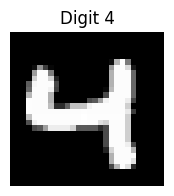

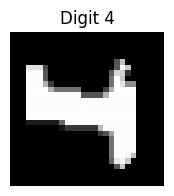

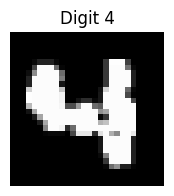

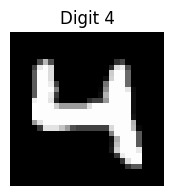

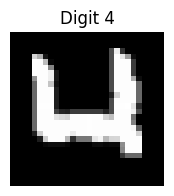

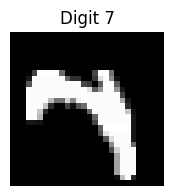

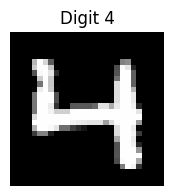

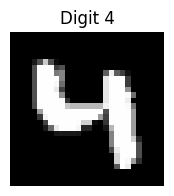

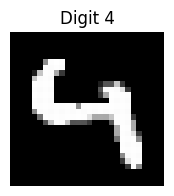

In [15]:
model = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new tree to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)
session = Session(
    data=final,
    metadata=np.arange(len(final)),
    model=model,
    decision_callback=decision,
    on_decision_callbacks=[
        TerminateAfter(EXPERT_BUDGET),
    ],
)
session.run()

Let's see what we have selected

In [16]:
n_anomalies = len(session.known_anomalies)
n_total = len(session.known_labels)
print(f"Anomalies: {n_anomalies}/{n_total} ({n_anomalies / n_total:.2%})")

Anomalies: 10/20 (50.00%)


Let's do the opposite: odd numbers are anomalies

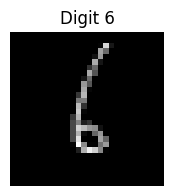

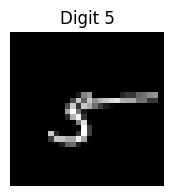

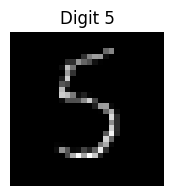

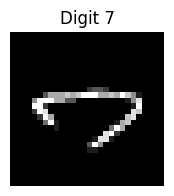

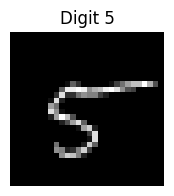

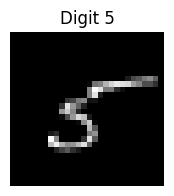

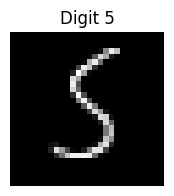

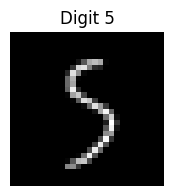

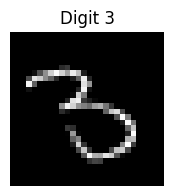

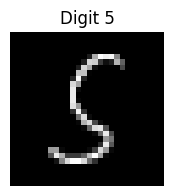

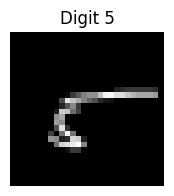

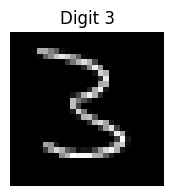

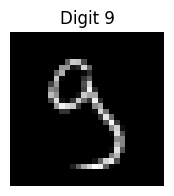

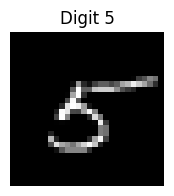

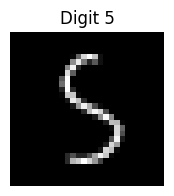

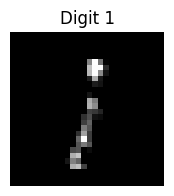

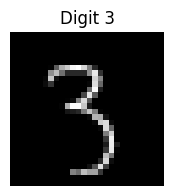

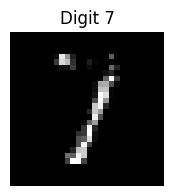

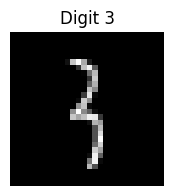

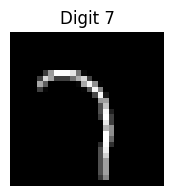

Anomalies: 19/20 (95.00%)


In [17]:
def decision(index, x, session):
    digit, image = digits[index], images[index]
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Digit {digit}')
    ax.axis('off')
    plt.show()

    ### UNCOMMENT TO MAKE IT INTERACTIVE
    # return prompt_decision_callback(index, x, session)

    # Non-interactive
    return Label.ANOMALY if digit % 2 == 1 else Label.REGULAR


model = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new tree to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)
session = Session(
    data=final,
    metadata=np.arange(len(final)),
    model=model,
    decision_callback=decision,
    on_decision_callbacks=[
        TerminateAfter(EXPERT_BUDGET),
    ],
)
session.run()

n_anomalies = len(session.known_anomalies)
n_total = len(session.known_labels)
print(f"Anomalies: {n_anomalies}/{n_total} ({n_anomalies / n_total:.2%})")

Change `decision` function to make it interactive and try your own experiments. For example, say yes to weird sevens only